# PHE Daily Cases

Created by Michael George (AKA Logiqx)

Website: https://logiqx.github.io/covid-stats/

## PHE Core

Import library for working with PHE data

In [704]:
import os
import csv

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import common_core
import phe_core

## Area Class

Supports a single area - nation, region, ltla, etc

In [705]:
class AreaWip(phe_core.Area):

    def __init__(self, areaType, areaName):
        """Initialisise the area object"""

        self.data = {}

        super().__init__(areaType, areaName)
        

    def test(self):
        print(self.areaName)
        
    def load(self, period, dirName):
        """Load demographic data - cases or deaths"""

        csvFn = os.path.join(common_core.projdir, "data", "phe-dashboard", "csv", period, dirName, self.areaType, self.csvName)

        try:
            with open(csvFn, 'r') as f:
                reader = csv.reader(f, delimiter = ',')
                
                dtype = []
                converters = {}
                colNames = next(reader)

                for i in range(len(colNames)):
                    # [('myint','i8'),('myfloat','f8'), ('mystring','S5')]
                    colName = colNames[i]
                    if colName == "date":
                        dtype.append((colName, "U10"))
                    elif colName == "areaName":
                        dtype.append((colName, "U40"))
                    elif colName.endswith("Rate"):
                        dtype.append((colName, "f8"))
                        converters[i] = lambda s: float(s or 0)
                    else:
                        dtype.append((colName, "u4"))
                        converters[i] = lambda s: int(s or 0)

                data = np.genfromtxt(f, dtype=dtype, converters=converters, delimiter=",")

            # Ensure period is present in data arrays
            if period not in self.data:
                self.data[period] = {}

            # Store the data
            self.data[period][dirName] = data

        # General catch all
        except:
            print(f"Failed to load {dirName} for {self.areaName}")
            raise


    def loadCases(self):
        """Load PHE cases data"""

        self.load("daily", "cases")
            

    def loadDeaths(self):
        """Load PHE deaths data"""

        self.load("daily", "deaths")

## Areas Class

Combines multiple areas - nation, region, ltla, etc

In [706]:
class AreasWip(phe_core.Area):

    def __init__(self):
        """Initialisise the area object"""

        self.areas = []

    
    def addArea(self, areaType, areaName):
        
        area = AreaWip(areaType, areaName)
        self.areas[(areaType, areaName)] = area
        

    def loadCases(self, areaType, areaName):
        
        area = AreaWip(areaType, areaName)
        #area = self.areas[(areaType, areaName)]
        area.loadCases()
        self.areas.append(area)
        

    def plotCases(self):
        """Plot cases by specimen date age demographics"""
        
        # print(area.data["daily"]["cases"]["casesReported"])
        
        # Create new figure
        plt.figure(clear=True, figsize=(16, 9))  
        
        # Plot data
        for area in self.areas:
            # Get all value up to the last non-zero
            tmp_points = np.array(area.data["daily"]["cases"]["casesReported"])
            idx = np.max(np.nonzero(tmp_points))
            tmp_points = tmp_points[:idx+1]

            # Calculate moving average
            #y_smooth = savgol_filter(y_points[:, plot], 51, 5)
            y_points = np.concatenate((np.zeros(3), np.convolve(tmp_points, np.ones(7)/7, mode=m)))
            x_points = np.arange(len(y_points))
            x_ticks = np.array(area.data["daily"]["cases"]["date"])[:idx+1]
            
            plt.plot(x_points, y_points, label = area.areaName) #, color='green', linewidth=2)
            #plt.plot(x_points, y_smooth, label = 'raw') #, color='green', linewidth=2)

        # Set xticks
        plt.xticks(np.arange(0, len(x_ticks), step=7), x_ticks[::7], rotation=90)
        
        # Add title, axis labels and legend
        plt.title('Daily Cases Test')
        plt.ylabel('Number of cases')
        plt.legend()
     
        # Show figure
        #plt.show()

## Load data into memory

In [707]:
areas = AreasWip()

for areaType, areaNames in phe_core.areas[2:3]:
    for areaName in areaNames:
        #print(f"Loading {areaName}...")
        areas.loadCases(areaType, areaName)

## Plot Daily Cases

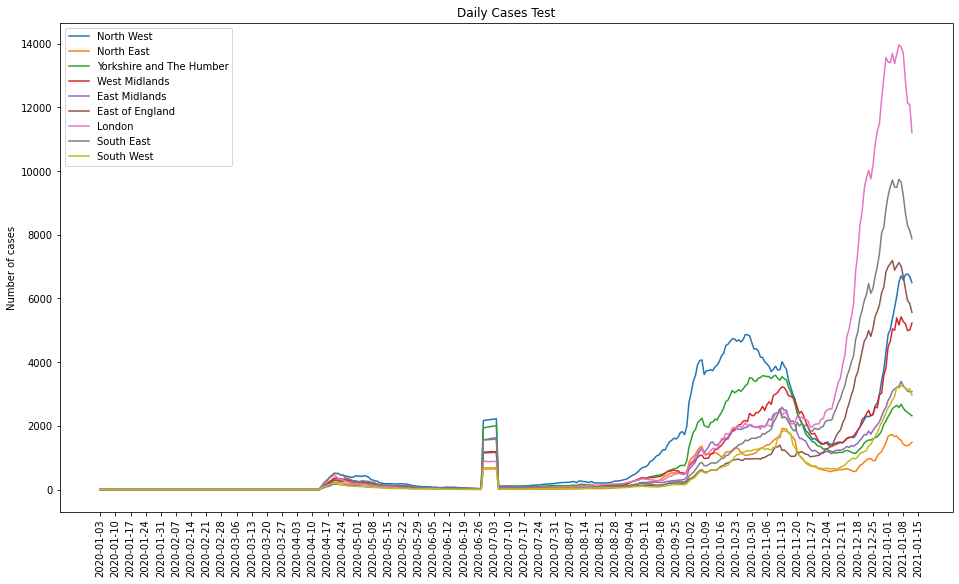

In [708]:
areas.plotCases()